In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

# Problem

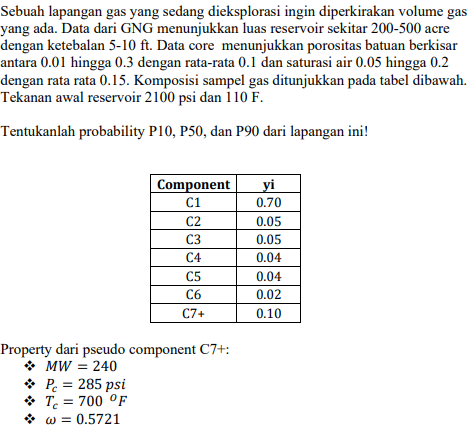

# Objective: Determine natural gas reserve for P10, P50, and P90 Probability

# Defining variables

## Composition dataset

In [187]:
dc=pd.read_csv('dataset\Data Komposisi.csv')
dc

,Component,yi,Tci,Pci,wi
0,C1,0.70,343.33,666.4,0.0104
1,C2,0.05,549.92,706.5,0.0989
2,C3,0.05,666.06,616.4,0.1522
3,C4,0.04,765.62,527.9,0.1852
4,C5,0.04,845.80,488.6,0.2280
5,C6,0.02,923.00,453.0,0.2500
6,C7+,0.10,1160.00,285.0,0.5721


In [188]:
Tres=110 # Fahrenheit
Pres=2100 #psia
Tres=Tres+460.67 #Rankine

In [189]:
#gas constant
R=10.732 #ft3 psia/Rankine lbmol

## Calculate z Factor from Peng Robinson Equation

In [190]:
#calculate k
dc['k']=0.37464+1.54226*dc['wi']-0.26992*dc['wi']**2

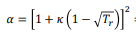

In [191]:
#calculate Tr
dc['Tr']=Tres/dc['Tci']

In [192]:
#calculate alpha
dc['alpha']=(1+dc['k']*(1-dc['Tr']**0.5))**2

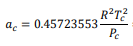

In [193]:
#calculate a
dc['a']=0.45723553*((R**2) * (dc['Tci']**2)/dc['Pci'])

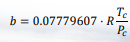

In [194]:
#calculate b
dc['b']=0.07779607 *(R * (dc['Tci'])/dc['Pci'])

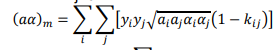

asumsi kij=0

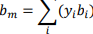

In [195]:
#calculate (a alpha)
sum_aalpha=0
sum_bm=0
for i in range(0, len(dc)):
    for j in range(0, len(dc)):
        sum_aalpha+=dc['yi'][i]*dc['yi'][j]*( ( dc['a'][i] * dc['a'][j]) * ( dc['alpha'][i] * dc['alpha'][j] ) )**0.5
    sum_bm+=dc['yi'][i]*dc['b'][i]
print(sum_aalpha)
print(sum_bm)

30674.71043338858
0.8587949011270013


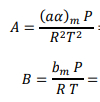

dilakukan pada P = 2100 psi dan T=110 Fahrenheit=570Rankine

In [196]:
#calculate A
A=sum_aalpha*Pres/( (R**2) * (Tres**2))
B=sum_bm*Pres/( (R) * (Tres))
print(A)
print(B)

1.7173877219437632
0.2944713488111235


**find z with newton rhapson method**

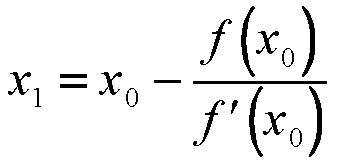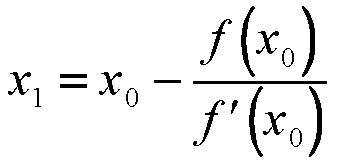

In [197]:
#calculate zfunct
def fungsiz(a,b,z):
    return(z**3-(1-b)*z**2+(a-3*b**2-2*b)*z-(a*b-b**2-b**3))
def dfungsiz(a,b,z):
    return(3*z**2-2*(1-b)*z+(a-3*b**2-2*b))

In [198]:
def hitungz(a,b):
    e=1
    zbaru=0
    zlama=1
    while e>0.0000001:
        func=fungsiz(a,b,zlama)
        dfunc=dfungsiz(a,b,zlama)
        zbaru=zlama-func/dfunc
        e=abs(zbaru-zlama)
        zlama=zbaru
    nilaiz=zlama
    return(nilaiz)

In [199]:
print('nilai z pada', Pres,'psia adalah', hitungz(A,B))

nilai z pada 2100 psia adalah 0.5116070234605818


## Calculate Bg(Gas formation volume factor)

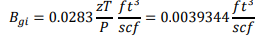

In [200]:
def bg(z,T,P):
    bgi=0.0283*z*T/P
    print(bg)#ft3/scf
    return(bgi)

In [201]:
print('nilai Bgi pada', Pres,'psia dan', round(Tres-460.67,0),'Fahrenheit adalah', round(bg(hitungz(A,B),Tres, Pres),6),'ft3/scf')

<function bg at 0x000002367B8D75E0>
nilai Bgi pada 2100 psia dan 110.0 Fahrenheit adalah 0.003934 ft3/scf


In [202]:
bgi=bg(hitungz(A,B),Tres, Pres)

<function bg at 0x000002367B8D75E0>


In [203]:
bgi

0.003934492131530706

# Estimate IGIP with Monte Carlo

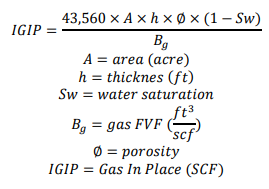

In [204]:
def calculate_IGIP(A,h,por,sw,Bg):
    IGIP=43560*A*h*por*(1-sw)/(Bg*10**9) #in BSCF
    return(IGIP)

**For Oil Reservoir OOIP(Original Oil in Place)**

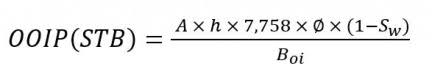

- A = area (acre)
- h = thickness (ft)
- Sw = Water saturation
- Porosity
- Boi = Oil FVF(bbl/stb)

In [1]:
def calculate_OOIP(A,h,por,sw,Bo):
    OOIP=7758*A*h*por*(1-sw)/(Bg*10**6) #in MMSTB
    return(OOIP)

## For 1000 iterations

### Property Distributions

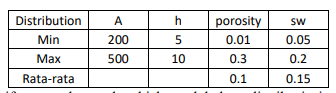

- A= area in acre
- h= thickness in ft
- Sw= Water saturation
- Porosity

In [205]:
#Distribusi area dalam bentuk uniform
iter=1000
area=np.random.uniform(200,500,iter)
#Distribusi thickness dalam bentuk uniform
thick=np.random.uniform(5,10,iter)
#Distribusi porosity dalam bentuk segitiga
por=np.random.triangular(0.01, 0.1, 0.3, iter) 
#Distribusi sw dalam bentuk segitiga
sw=np.random.triangular(0.05, 0.15, 0.2, iter)

In [206]:
calc_igip=pd.DataFrame({'Area':area,
                        'Thickness':thick,
                        'Porosity':por,
                        'Sw':sw})
calc_igip.head()

,Area,Thickness,Porosity,Sw
0,286.175799,8.867759,0.196492,0.124916
1,226.718324,7.164608,0.042098,0.139372
2,477.015536,6.838126,0.116052,0.162053
3,230.398091,9.926461,0.126119,0.123566
4,439.051538,8.018651,0.119346,0.146543


In [207]:
col=list(calc_igip.columns)
col

['Area', 'Thickness', 'Porosity', 'Sw']

**Plot property distributions**

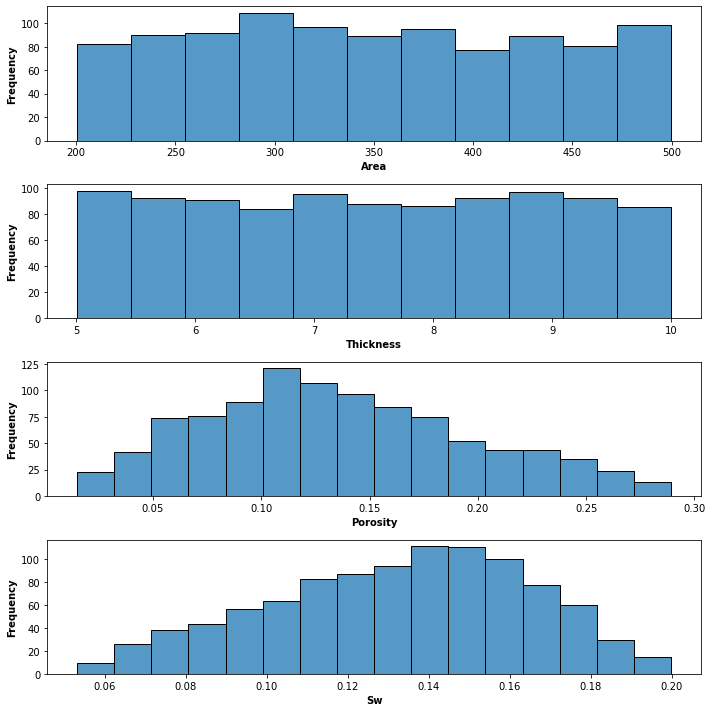

In [208]:
fig, axes=plt.subplots(4,1,figsize=(10,10))
for i in range(0, len(col)):
    sns.histplot(x=calc_igip[col[i]], ax=axes[i])
    axes[i].set_xlabel(col[i], weight='bold')
    axes[i].set_ylabel('Frequency', weight='bold')
    plt.tight_layout()
fig.show()
fig.savefig('Graph/1000_Property_Distributions.jpg')

### Determine Natural Gas reserve for P10, P50, and P90

In [209]:
#Calculate IGIP
calc_igip['IGIP']=calculate_IGIP(calc_igip['Area'],calc_igip['Thickness'], calc_igip['Porosity'], calc_igip['Sw'],bgi)
calc_igip.head()

,Area,Thickness,Porosity,Sw,IGIP
0,286.175799,8.867759,0.196492,0.124916,4.831032
1,226.718324,7.164608,0.042098,0.139372,0.651562
2,477.015536,6.838126,0.116052,0.162053,3.511873
3,230.398091,9.926461,0.126119,0.123566,2.798807
4,439.051538,8.018651,0.119346,0.146543,3.970124


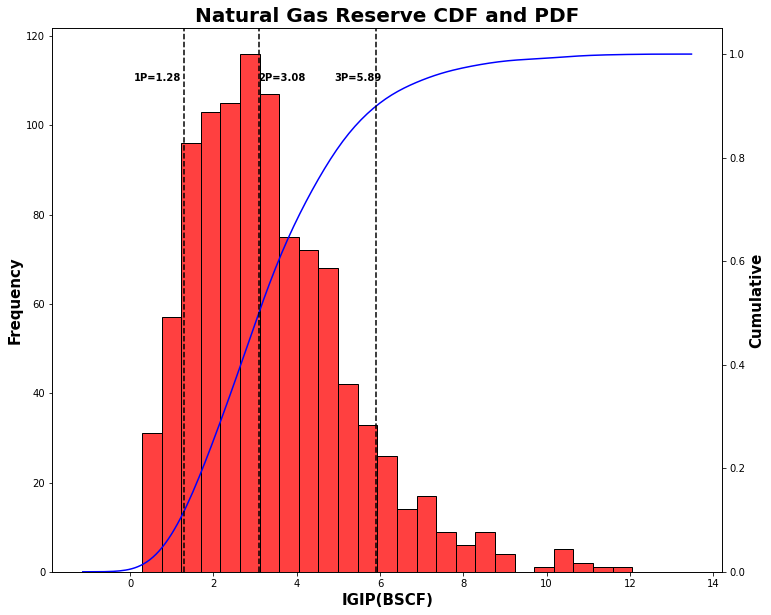

In [212]:
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
ax2 = ax.twinx()

sns.histplot(x=calc_igip['IGIP'], color='red', ax=ax)
ax.set_ylabel('Frequency', weight='bold', size=15)
sns.kdeplot(x=calc_igip['IGIP'], color='blue', ax=ax2, cumulative=True)
ax2.set_ylabel('Cumulative', weight='bold', size=15)
ax.set_xlabel('IGIP(BSCF)', weight='bold', size=15)
plt.title('Natural Gas Reserve CDF and PDF', weight='bold', size=20)
plt.axvline(np.percentile(calc_igip['IGIP'], 10), color='black', linestyle='--')
plt.axvline(np.percentile(calc_igip['IGIP'], 50), color='black', linestyle='--')
plt.axvline(np.percentile(calc_igip['IGIP'], 90), color='black', linestyle='--')
ax.text(x=np.percentile(calc_igip['IGIP'], 10)-1.2, y=110, s='1P='+str(round(np.percentile(calc_igip['IGIP'], 10),2)), weight='bold')
ax.text(x=np.percentile(calc_igip['IGIP'], 50), y=110, s='2P='+str(round(np.percentile(calc_igip['IGIP'], 50),2)), weight='bold')
ax.text(x=np.percentile(calc_igip['IGIP'], 90)-1, y=110, s='3P='+str(round(np.percentile(calc_igip['IGIP'], 90),2)), weight='bold')
plt.show()
fig.savefig('Graph/1000_Natural Gas Reserve CDF and PDF.jpg')

In [213]:
p10=round(np.percentile(calc_igip['IGIP'], 10), 2)
p50=round(np.percentile(calc_igip['IGIP'], 50), 2)
p90=round(np.percentile(calc_igip['IGIP'], 90), 2)

In [214]:
print('1P(Proved) atau P90 Reserve :', p10)
print('2P(Proved + Probable) atau P50 Reserve :', p50)
print('3P(Proved + Probable + Possible) atau P90 Reserve :', p90)

1P(Proved) atau P90 Reserve : 1.28
2P(Proved + Probable) atau P50 Reserve : 3.08
3P(Proved + Probable + Possible) atau P90 Reserve : 5.89


In [216]:
#export result calculation to csv
calc_igip.to_csv('Output Result\Hasil Simulasi 1000 iterasi.csv', index=False)

## For 10000 iterations

### Property Distributions

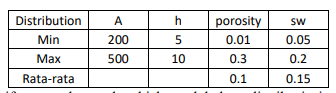

- A= area in acre
- h= thickness in ft
- Sw= Water saturation
- Porosity

In [217]:
#Distribusi area dalam bentuk uniform
iter=10**4
area=np.random.uniform(200,500,iter)
#Distribusi thickness dalam bentuk uniform
thick=np.random.uniform(5,10,iter)
#Distribusi porosity dalam bentuk segitiga
por=np.random.triangular(0.01, 0.1, 0.3, iter) 
#Distribusi sw dalam bentuk segitiga
sw=np.random.triangular(0.05, 0.15, 0.2, iter)

In [218]:
calc_igip=pd.DataFrame({'Area':area,
                        'Thickness':thick,
                        'Porosity':por,
                        'Sw':sw})
calc_igip.head()

,Area,Thickness,Porosity,Sw
0,487.417988,8.184334,0.262884,0.150481
1,306.630576,5.727194,0.176943,0.178352
2,470.685410,9.398402,0.105240,0.084315
3,229.191666,8.166025,0.220252,0.151129
4,274.764419,6.352233,0.133903,0.160385


In [219]:
col=list(calc_igip.columns)
col

['Area', 'Thickness', 'Porosity', 'Sw']

**Plot property distributions**

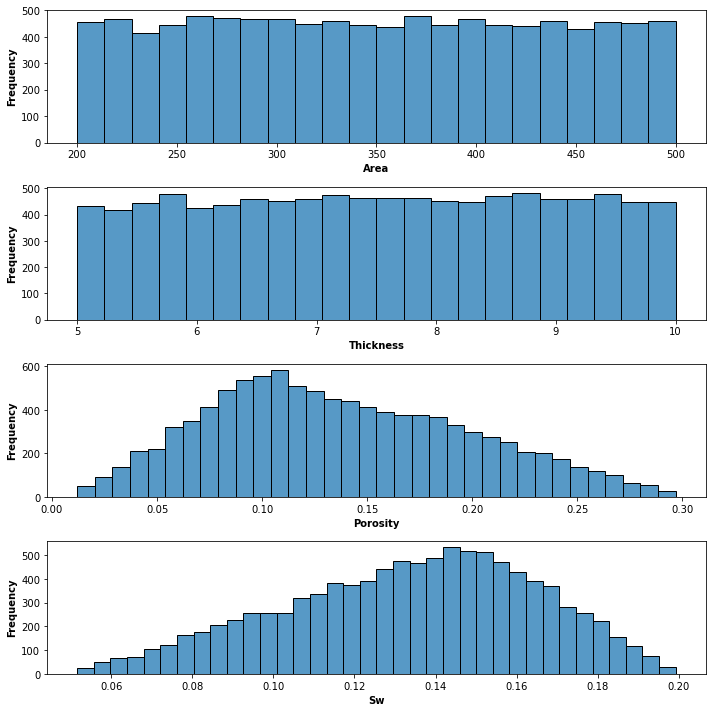

In [220]:
fig, axes=plt.subplots(4,1,figsize=(10,10))
for i in range(0, len(col)):
    sns.histplot(x=calc_igip[col[i]], ax=axes[i])
    axes[i].set_xlabel(col[i], weight='bold')
    axes[i].set_ylabel('Frequency', weight='bold')
    plt.tight_layout()
fig.show()
fig.savefig('Graph/10000_Property_Distributions.jpg')

### Determine Natural Gas reserve for P10, P50, and P90

In [221]:
#Calculate IGIP
calc_igip['IGIP']=calculate_IGIP(calc_igip['Area'],calc_igip['Thickness'], calc_igip['Porosity'], calc_igip['Sw'],bgi)
calc_igip.head()

,Area,Thickness,Porosity,Sw,IGIP
0,487.417988,8.184334,0.262884,0.150481,9.863300
1,306.630576,5.727194,0.176943,0.178352,2.826682
2,470.685410,9.398402,0.105240,0.084315,4.719647
3,229.191666,8.166025,0.220252,0.151129,3.874103
4,274.764419,6.352233,0.133903,0.160385,2.172485


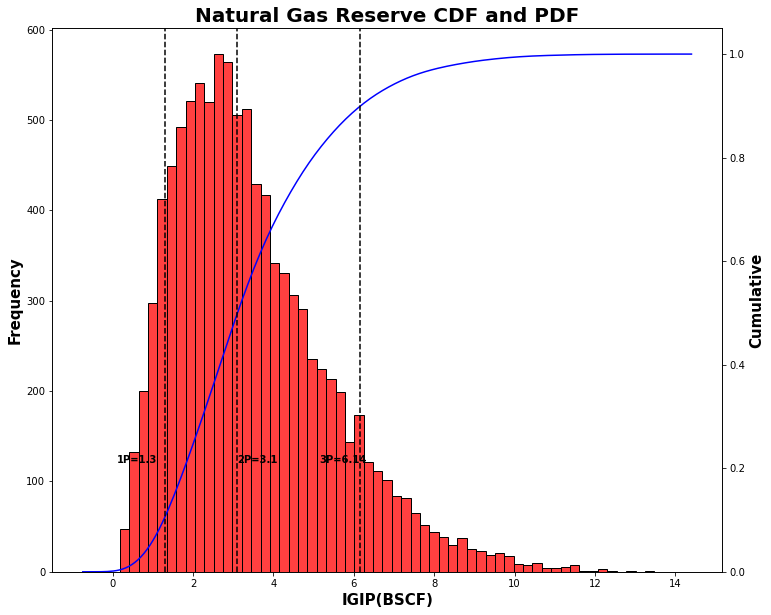

In [222]:
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
ax2 = ax.twinx()

sns.histplot(x=calc_igip['IGIP'], color='red', ax=ax)
ax.set_ylabel('Frequency', weight='bold', size=15)
sns.kdeplot(x=calc_igip['IGIP'], color='blue', ax=ax2, cumulative=True)
ax2.set_ylabel('Cumulative', weight='bold', size=15)
ax.set_xlabel('IGIP(BSCF)', weight='bold', size=15)
plt.title('Natural Gas Reserve CDF and PDF', weight='bold', size=20)
plt.axvline(np.percentile(calc_igip['IGIP'], 10), color='black', linestyle='--')
plt.axvline(np.percentile(calc_igip['IGIP'], 50), color='black', linestyle='--')
plt.axvline(np.percentile(calc_igip['IGIP'], 90), color='black', linestyle='--')
ax.text(x=np.percentile(calc_igip['IGIP'], 10)-1.2, y=120, s='1P='+str(round(np.percentile(calc_igip['IGIP'], 10),2)), weight='bold')
ax.text(x=np.percentile(calc_igip['IGIP'], 50), y=120, s='2P='+str(round(np.percentile(calc_igip['IGIP'], 50),2)), weight='bold')
ax.text(x=np.percentile(calc_igip['IGIP'], 90)-1, y=120, s='3P='+str(round(np.percentile(calc_igip['IGIP'], 90),2)), weight='bold')
plt.show()
fig.savefig('Graph/10000_Natural Gas Reserve CDF and PDF.jpg')

In [223]:
p10=round(np.percentile(calc_igip['IGIP'], 10), 2)
p50=round(np.percentile(calc_igip['IGIP'], 50), 2)
p90=round(np.percentile(calc_igip['IGIP'], 90), 2)

In [224]:
print('1P(Proved) atau P90 Reserve :', p10)
print('2P(Proved + Probable) atau P50 Reserve :', p50)
print('3P(Proved + Probable + Possible) atau P90 Reserve :', p90)

1P(Proved) atau P90 Reserve : 1.3
2P(Proved + Probable) atau P50 Reserve : 3.1
3P(Proved + Probable + Possible) atau P90 Reserve : 6.14


In [225]:
#export result calculation to csv
calc_igip.to_csv('Output Result\Hasil Simulasi 10000 iterasi.csv', index=True)